In [1]:
!pip install folium

     -------------------------------------- 100.3/100.3 kB 5.6 MB/s eta 0:00:00


In [190]:
import pandas as pd
import re
from ast import literal_eval
import numpy as np
import folium 
import json
import requests
import branca
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
plt.rc('font', family='Malgun Gothic')

# 음식점 데이터 합치기

In [ ]:
df1 = pd.read_csv('fulldata_07_24_04_P_일반음식점.csv', encoding='CP949')
df2 = pd.read_csv('fulldata_07_24_05_P_휴게음식점.csv', encoding='CP949')

df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# 데이터 전처리

In [ ]:
# 특정 필드만 추출
df = df[['인허가일자', '인허가취소일자', '영업상태명', '폐업일자', '소재지전체주소', '도로명전체주소', '사업장명', '업태구분명', '좌표정보(x)', '좌표정보(y)', '영업장주변구분명', '다중이용업소여부']]

In [ ]:
## 영업 기간 구하기

### 불필요, 잘못된 데이터 drop
df = df[df['좌표정보(y)'] != '한식'].reset_index(drop=True)
df = df[~df['사업장명'].str.contains('pc|PC', na=False)]
df = df[~df['업태구분명'].str.contains('편의점', na=False)]

### 좌표 정보 형변환
df['좌표정보(y)'] = df['좌표정보(y)'].astype('float64')

### 폐업일자 결측치 처리

df = df[~((df['영업상태명']=='폐업') & (pd.isna(df['폐업일자'])))].reset_index(drop=True)

now = datetime.datetime.now()
now_time = f'{now.year}-{now.month}-{now.day}'

df['폐업일자'] = df['폐업일자'].fillna(now_time)

### date 형식에 맞지 않는 행 drop

delete_list_1 = []
delete_list_2 = []
for i in tqdm(range(0, len(df)-1)):
  try:
    datetime.datetime.strptime(df.loc[i, '인허가일자'], '%Y-%m-%d')
  except:
    delete_list_1.append(df.loc[i, '인허가일자'])

  try:
    datetime.datetime.strptime(df.loc[i, '폐업일자'], '%Y-%m-%d')
  except:
    delete_list_2.append(df.loc[i, '폐업일자'])

df = df[(~df['인허가일자'].isin(delete_list_1)) & (~df['폐업일자'].isin(delete_list_2))].reset_index(drop=True)

### 폐업일자, 인허가일자 date type으로 형변환
df['폐업일자'] = pd.to_datetime(df['폐업일자'])
df['인허가일자'] = pd.to_datetime(df['인허가일자'])

### 영업 기간 컬럼 생성
df['영업 기간'] = df.apply(lambda n : n['폐업일자']-n['인허가일자'], axis=1)

In [ ]:
### 중부원점 좌표 변환
def project_array(coord) -> tuple:
    p1 = pyproj.Proj(init='EPSG:2097')
    p2 = pyproj.Proj(init='EPSG:4326')
    fx, fy = pyproj.transform(p1, p2, coord.loc[:, '좌표정보(x)'], coord.loc[:, '좌표정보(y)'])
    return (fx, fy)

df.loc[:, '좌표정보(x)'], df.loc[:, '좌표정보(y)'] = project_array(df)

In [ ]:
# 필드 이름 영어로 변환
df_fields = ['licence_date', 'licence_cancel_date', 'status', 'close_date', 'location_number_address', 'street_name_address', 'store_name', 'category', 'longitude', 'latitude', 
             'business_area_name', 'multi_business', 'period']

df.columns = df_fields

## BIgQuery에서 처리



### 1차 전처리


```sql
SELECT *, 
  (CASE 
    WHEN store_name LIKE '%공차%' THEN '공차'
    WHEN store_name LIKE '%명랑%핫도그%' THEN '명랑핫도그'
    WHEN store_name LIKE '%설빙%' THEN '설빙'
    WHEN store_name LIKE '%마라탕%' THEN '마라탕'
    WHEN store_name LIKE '%엽기%떡볶이%' THEN '엽기떡볶이'
    WHEN store_name LIKE '%카스테라%' THEN '카스테라'
    WHEN store_name LIKE '%쥬씨%' THEN '쥬씨'
    WHEN store_name LIKE '%엉터리%생고기%' THEN '엉터리생고기'
    WHEN store_name LIKE '%홍루이젠%' THEN '홍루이젠'
    WHEN store_name LIKE '%밥버거%' THEN '밥버거'
    WHEN store_name LIKE '%탕후루%' THEN '탕후루'
  END) AS keyword,
  (CASE 
    WHEN store_name LIKE '%공차%' THEN 'steady'
    WHEN store_name LIKE '%명랑%핫도그%' THEN 'steady'
    WHEN store_name LIKE '%설빙%' THEN 'steady'
    WHEN store_name LIKE '%마라탕%' THEN 'steady'
    WHEN store_name LIKE '%엽기%떡볶이%' THEN 'steady'
    WHEN store_name LIKE '%카스테라%' THEN 'trendy'
    WHEN store_name LIKE '%쥬씨%' THEN 'trendy'
    WHEN store_name LIKE '%엉터리%생고기%' THEN 'trendy'
    WHEN store_name LIKE '%홍루이젠%' THEN 'trendy'
    WHEN store_name LIKE '%밥버거%' THEN 'trendy'
    WHEN store_name LIKE '%탕후루%' THEN 'tang'
  END) AS class
FROM `temp.store_data`
WHERE (store_name LIKE '%공차%'
  OR store_name LIKE '%명랑%핫도그%'
  OR store_name LIKE '%설빙%'
  OR store_name LIKE '%마라탕%'
  OR store_name LIKE '%엽기%떡볶이%'
  OR store_name LIKE '%카스테라%'
  OR store_name LIKE '%쥬씨%'
  OR store_name LIKE '%엉터리%생고기%'
  OR store_name LIKE '%홍루이젠%'
  OR store_name LIKE '%밥버거%'
  OR store_name LIKE '%탕후루%')
  AND (licence_date >= '2009-01-01')
  AND (longitude IS NOT NULL)
```

### 카테고리로 묶기

```sql
SELECT class as category
  , EXTRACT(YEAR FROM licence_date) AS year
  , EXTRACT(MONTH FROM licence_date) AS month
  , ARRAY_AGG(store_name) as store_name
  , ARRAY_AGG(concat(longitude, ' ', latitude)) as total_location
  , ARRAY_AGG(IF(status = '영업/정상', CONCAT(longitude, ' ', latitude), '')) AS normal_location
  , ARRAY_AGG(IF(status = '폐업', CONCAT(longitude, ' ', latitude), '')) AS close_location
  # , ARRAY_AGG(CASE WHEN status = '영업/정상' THEN CONCAT(longitude, ' ', latitude) ELSE NULL END) AS normal_location
  # , ARRAY_AGG(CASE WHEN status = '폐업' THEN CONCAT(longitude, ' ', latitude) ELSE '' END) AS close_location
  , ARRAY_AGG(licence_date) as open_date
  , ARRAY_AGG(close_date) as close_date
  , ARRAY_LENGTH(ARRAY_AGG(store_name)) as store_count
  , SUM(CASE WHEN status = '영업/정상' THEN 1 ELSE 0 END) AS count_normal
  , SUM(CASE WHEN status = '폐업' THEN 1 ELSE 0 END) AS count_closed

FROM `temp.store_v1`
GROUP BY class, year, month
ORDER BY class, year, month
```

### 키워드로 묶기
```
SELECT keyword
  , EXTRACT(YEAR FROM licence_date) AS year
  , EXTRACT(MONTH FROM licence_date) AS month
  , ARRAY_AGG(store_name) as store_name
  , ARRAY_AGG(concat(longitude, ' ', latitude)) as total_location
  , ARRAY_AGG(IF(status = '영업/정상', CONCAT(longitude, ' ', latitude), '')) AS normal_location
  , ARRAY_AGG(IF(status = '폐업', CONCAT(longitude, ' ', latitude), '')) AS close_location
  # , ARRAY_AGG(CASE WHEN status = '영업/정상' THEN CONCAT(longitude, ' ', latitude) ELSE NULL END) AS normal_location
  # , ARRAY_AGG(CASE WHEN status = '폐업' THEN CONCAT(longitude, ' ', latitude) ELSE '' END) AS close_location
  , ARRAY_AGG(licence_date) as open_date
  , ARRAY_AGG(close_date) as close_date
  , ARRAY_LENGTH(ARRAY_AGG(store_name)) as store_count
  , SUM(CASE WHEN status = '영업/정상' THEN 1 ELSE 0 END) AS count_normal
  , SUM(CASE WHEN status = '폐업' THEN 1 ELSE 0 END) AS count_closed

FROM `temp.store_v1`
GROUP BY keyword, year, month
ORDER BY keyword, year, month

```

In [2]:
df = pd.read_csv('store_keyword.csv')

In [3]:
df['store_name'] = df['store_name'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['total_location'] = df['total_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['normal_location'] = df['normal_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['close_location'] = df['close_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['open_date'] = df['open_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df['close_date'] = df['close_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)

# 타임 스탬프 반영 지도 그리기

In [4]:
boom = {}

In [5]:
boom['밥버거'] = (2013, 10)
boom['쥬씨'] = (2016, 6)
boom['카스테라'] = (2016, 12)
boom['홍루이젠'] = (2018, 8)
boom['엉터리생고기'] = (2016, 5)
boom['설빙'] = (2016, 7)
boom['공차'] = (2020, 2)
boom['명랑핫도그'] = (2017, 3)
boom['마라탕'] = (2019, 6)
boom['엽기떡볶이'] = (2015 ,4)
boom['탕후루'] = (2022, 12)

In [6]:
class KeywordMapImage():
    def __init__(self, data, keywords, boom):
        self.data = data
        self.keywords = keywords
        self.boom = boom
        
    def get_heatmap_boom(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)
            
            boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
            data_frame_before = data_frame.iloc[0:boom_index,:]
            data_frame_after = data_frame.iloc[boom_index:len(data_frame),:]
            
            data_before = []
            for i in range(len(data_frame_before['total_location'])):
                for j in range(len(data_frame_before['total_location'][i])):
                    data_before.append([data_frame_before['total_location'][i][j].split(' ')[1], data_frame_before['total_location'][i][j].split(' ')[0]])
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data_before, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_before.html')
            
            data_after = []
            for i in range(boom_index, data_frame.iloc[-1].name, 1):
                for j in range(len(data_frame_after['total_location'][i])):
                    data_after.append([data_frame_after['total_location'][i][j].split(' ')[1], data_frame_after['total_location'][i][j].split(' ')[0]])

            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data_after, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_after.html')
            
    def get_heatmap_all(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)
            
            data = []
            for i in range(len(data_frame['total_location'])):
                for j in range(len(data_frame['total_location'][i])):
                    data.append([data_frame['total_location'][i][j].split(' ')[1], data_frame['total_location'][i][j].split(' ')[0]])
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_all.html')
            
    def get_timemap_all(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)

            # 날짜 만들어주기
            data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
            time_index=data_frame['date'].tolist()

            # 위치 정보 누적으로 묶어주기
            data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])

            for i in range(len(data_frame['total_location'])):
                for j in range(len(data_frame['total_location'][i])):
                    data_frame['total_location'][i][j][1], data_frame['total_location'][i][j][0] = float(data_frame['total_location'][i][j][0]), float(data_frame['total_location'][i][j][1])

            for i in range(0, len(data_frame['total_location'])-2, 1):
                data_frame['total_location'][i+1].extend(data_frame['total_location'][i])

            data = data_frame['total_location'].tolist()


            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)

            hm = folium.plugins.HeatMapWithTime(data, index=time_index, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)

            hm.add_to(m)

            m.save(f'{keyword}_timemap_all.html')
            
    def get_timemap_boom(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)

            # 날짜 만들어주기
            data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
            time_index=data_frame['date'].tolist()

            # 위치 정보 누적으로 묶어주기
            data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])

            for i in range(len(data_frame['total_location'])):
                for j in range(len(data_frame['total_location'][i])):
                    data_frame['total_location'][i][j][1], data_frame['total_location'][i][j][0] = float(data_frame['total_location'][i][j][0]), float(data_frame['total_location'][i][j][1])

            for i in range(0, len(data_frame['total_location'])-2, 1):
                data_frame['total_location'][i+1].extend(data_frame['total_location'][i])
            
            boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
            
            data_frame_before = data_frame.iloc[0:boom_index,:]
            data_frame_after = data_frame.iloc[boom_index:len(data_frame),:].reset_index(drop=True)
            
            data_before = data_frame_before['total_location'].tolist()
            data_after = data_frame_after['total_location'].tolist()

            time_index_before = time_index[:boom_index]
            time_index_after = time_index[boom_index:]
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            hm = folium.plugins.HeatMapWithTime(data_before, index=time_index_before, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)
            hm.add_to(m)
            
            m.save(f'{keyword}_timemap_before.html')
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            hm = folium.plugins.HeatMapWithTime(data_after, index=time_index_after, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)
            hm.add_to(m)
            
            m.save(f'{keyword}_timemap_after.html')
            
#     def get_timestamp_merge(self):
#         # trendy, steady 데이터 따로 분리
#         data_trendy = self.data[self.data['category']=='trendy'].reset_index(drop=True)
#         data_steady = self.data[self.data['category']=='steady'].reset_index(drop=True)
        
#         # 
        
        

In [7]:
keywords = set(df['keyword'])
key_map_image = KeywordMapImage(df, keywords, boom)
key_map_image.get_timemap_boom()
key_map_image.get_timemap_all()
key_map_image.get_heatmap_boom()
key_map_image.get_heatmap_all()


C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:84: SettingWithCopyWarning

C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:84: SettingWithCopyWarning

C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\sjhty\AppData\Local\Temp\ipykernel_2772\1146209537.py:54: SettingWithCopyWarning

# 클래스 기준 (steady, trendy)

In [75]:
df_class = pd.read_csv('store_class.csv')

In [76]:
df_class[df_class['category']!='tang'].reset_index(drop=True, inplace=True)

In [77]:
df_class['store_name'] = df_class['store_name'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df_class['total_location'] = df_class['total_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df_class['normal_location'] = df_class['normal_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df_class['close_location'] = df_class['close_location'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df_class['open_date'] = df_class['open_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)
df_class['close_date'] = df_class['close_date'].apply(lambda n: n.strip('[]').split(',') if n != '[,]' and n != '[]' else None)

In [87]:
class CategoryMapImage():
    def __init__(self, data):
        self.data = data
        self.categories = set(data['category'])
#         self.boom = boom
        
#     def get_heatmap_boom(self) -> None:
#         for keyword in self.keywords:
#             data_frame = self.data[self.data['keyword']==keyword]
#             data_frame.reset_index(drop=True, inplace=True)
            
#             boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
#             data_frame_before = data_frame.iloc[0:boom_index,:]
#             data_frame_after = data_frame.iloc[boom_index:len(data_frame),:]
            
#             data_before = []
#             for i in range(len(data_frame_before['total_location'])):
#                 for j in range(len(data_frame_before['total_location'][i])):
#                     data_before.append([data_frame_before['total_location'][i][j].split(' ')[1], data_frame_before['total_location'][i][j].split(' ')[0]])
            
#             m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
#             HeatMap(data_before, radius=7, min_opacity=1).add_to(m)
#             m.save(f'{keyword}_heatmap_before.html')
            
#             data_after = []
#             for i in range(boom_index, data_frame.iloc[-1].name, 1):
#                 for j in range(len(data_frame_after['total_location'][i])):
#                     data_after.append([data_frame_after['total_location'][i][j].split(' ')[1], data_frame_after['total_location'][i][j].split(' ')[0]])

#             m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
#             HeatMap(data_after, radius=7, min_opacity=1).add_to(m)
#             m.save(f'{keyword}_heatmap_after.html')
            
    def get_heatmap_all(self) -> None:
        for category in self.categories:
            data_frame = self.data[self.data['category']==category]
            data_frame.reset_index(drop=True, inplace=True)
            
            data = []
            for i in range(len(data_frame['total_location'])):
                for j in range(len(data_frame['total_location'][i])):
                    data.append([data_frame['total_location'][i][j].split(' ')[1], data_frame['total_location'][i][j].split(' ')[0]])
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data, radius=7, min_opacity=1).add_to(m)
            m.save(f'{category}_heatmap_all.html')
            
    def get_timemap_all(self) -> None:
        for category in self.categories:
            data_frame = self.data[self.data['category']==category]
            data_frame.reset_index(drop=True, inplace=True)

            # 날짜 만들어주기
            data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
            time_index=data_frame['date'].tolist()

            # 위치 정보 누적으로 묶어주기
            data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])

            for i in range(len(data_frame['total_location'])):
                for j in range(len(data_frame['total_location'][i])):
                    data_frame['total_location'][i][j][1], data_frame['total_location'][i][j][0] = float(data_frame['total_location'][i][j][0]), float(data_frame['total_location'][i][j][1])

            for i in range(0, len(data_frame['total_location'])-2, 1):
                data_frame['total_location'][i+1].extend(data_frame['total_location'][i])

            data = data_frame['total_location'].tolist()


            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)

            hm = folium.plugins.HeatMapWithTime(data, index=time_index, radius=8, auto_play=True, min_opacity=0.3, max_speed=30)

            hm.add_to(m)

            m.save(f'{category}_timemap_all.html')
            
#     def get_timemap_boom(self) -> None:
#         for keyword in self.keywords:
#             data_frame = self.data[self.data['keyword']==keyword]
#             data_frame.reset_index(drop=True, inplace=True)

#             # 날짜 만들어주기
#             data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
#             time_index=data_frame['date'].tolist()

#             # 위치 정보 누적으로 묶어주기
#             data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])

#             for i in range(len(data_frame['total_location'])):
#                 for j in range(len(data_frame['total_location'][i])):
#                     data_frame['total_location'][i][j][1], data_frame['total_location'][i][j][0] = float(data_frame['total_location'][i][j][0]), float(data_frame['total_location'][i][j][1])

#             for i in range(0, len(data_frame['total_location'])-2, 1):
#                 data_frame['total_location'][i+1].extend(data_frame['total_location'][i])
            
#             boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
            
#             data_frame_before = data_frame.iloc[0:boom_index,:]
#             data_frame_after = data_frame.iloc[boom_index:len(data_frame),:].reset_index(drop=True)
            
#             data_before = data_frame_before['total_location'].tolist()
#             data_after = data_frame_after['total_location'].tolist()

#             time_index_before = time_index[:boom_index]
#             time_index_after = time_index[boom_index:]
            
#             m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
#             hm = folium.plugins.HeatMapWithTime(data_before, index=time_index_before, radius=8, auto_play=True, min_opacity=0.3, max_speed=30)
#             hm.add_to(m)
            
#             m.save(f'{keyword}_timemap_before.html')
            
#             m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
#             hm = folium.plugins.HeatMapWithTime(data_after, index=time_index_after, radius=8, auto_play=True, min_opacity=0.3, max_speed=30)
#             hm.add_to(m)
            
#             m.save(f'{keyword}_timemap_after.html')
            
#     def get_timestamp_merge(self):
#         # trendy, steady 데이터 따로 분리
#         data_trendy = self.data[self.data['category']=='trendy'].reset_index(drop=True)
#         data_steady = self.data[self.data['category']=='steady'].reset_index(drop=True)
        
#         # 
        
        

In [88]:
category_map_image = CategoryMapImage(df_class)

In [89]:
category_map_image.get_heatmap_all()
category_map_image.get_timemap_all()

C:\Users\user\AppData\Local\Temp\ipykernel_12292\2467130157.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\user\AppData\Local\Temp\ipykernel_12292\2467130157.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\user\AppData\Local\Temp\ipykernel_12292\2467130157.py:54: SettingWithCopyWarning

# 폐업 기준으로 봐보자

In [180]:
class KeywordMapImageClose():
    def __init__(self, data, keywords, boom):
        self.data = data
        self.keywords = keywords
        self.boom = boom
        
    def get_heatmap_boom(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)
            
            boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
            data_frame_before = data_frame.iloc[0:boom_index,:]
            data_frame_after = data_frame.iloc[boom_index:len(data_frame),:]
            
            data_before = []
            for i in range(len(data_frame_before['close_location'])):
                for j in range(len(data_frame_before['close_location'][i])):
                    data_before.append([data_frame_before['close_location'][i][j].split(' ')[1], data_frame_before['close_location'][i][j].split(' ')[0]])
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data_before, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_before.html')
            
            data_after = []
            for i in range(boom_index, data_frame.iloc[-1].name, 1):
                for j in range(len(data_frame_after['close_location'][i])):
                    data_after.append([data_frame_after['close_location'][i][j].split(' ')[1], data_frame_after['close_location'][i][j].split(' ')[0]])

            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data_after, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_after.html')
            
    def get_heatmap_all(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)
            
            data = []
            for i in range(len(data_frame['close_location'])):
                for j in range(len(data_frame['close_location'][i])):
                    data.append([data_frame['close_location'][i][j].split(' ')[1], data_frame['close_location'][i][j].split(' ')[0]])
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            HeatMap(data, radius=20, min_opacity=0.1, miax_opacity=0.5, blur=30).add_to(m)
            m.save(f'{keyword}_heatmap_all.html')
            
    def get_timemap_all(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)

            # 날짜 만들어주기
            data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
            time_index=data_frame['date'].tolist()

            # 위치 정보 누적으로 묶어주기
            data_frame['close_location'] = data_frame['close_location'].apply(lambda n: [li.split(' ') for li in n])

            for i in range(len(data_frame['close_location'])):
                for j in range(len(data_frame['close_location'][i])):
                    data_frame['close_location'][i][j][1], data_frame['close_location'][i][j][0] = float(data_frame['close_location'][i][j][0]), float(data_frame['close_location'][i][j][1])

            for i in range(0, len(data_frame['close_location'])-2, 1):
                data_frame['close_location'][i+1].extend(data_frame['close_location'][i])

            data = data_frame['close_location'].tolist()


            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)

            hm = folium.plugins.HeatMapWithTime(data, index=time_index, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)

            hm.add_to(m)

            m.save(f'{keyword}_timemap_all.html')
            
    def get_timemap_boom(self) -> None:
        for keyword in self.keywords:
            data_frame = self.data[self.data['keyword']==keyword]
            data_frame.reset_index(drop=True, inplace=True)

            # 날짜 만들어주기
            data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
            time_index=data_frame['date'].tolist()

            # 위치 정보 누적으로 묶어주기
            data_frame['close_location'] = data_frame['close_location'].apply(lambda n: [li.split(' ') for li in n])

            for i in range(len(data_frame['close_location'])):
                for j in range(len(data_frame['close_location'][i])):
                    data_frame['close_location'][i][j][1], data_frame['close_location'][i][j][0] = float(data_frame['close_location'][i][j][0]), float(data_frame['close_location'][i][j][1])

            for i in range(0, len(data_frame['close_location'])-2, 1):
                data_frame['close_location'][i+1].extend(data_frame['total_location'][i])
            
            boom_index = data_frame[(data_frame['year'] == self.boom[keyword][0]) & (data_frame['month'] == self.boom[keyword][1])].index.values[0]
            
            data_frame_before = data_frame.iloc[0:boom_index,:]
            data_frame_after = data_frame.iloc[boom_index:len(data_frame),:].reset_index(drop=True)
            
            data_before = data_frame_before['close_location'].tolist()
            data_after = data_frame_after['close_location'].tolist()

            time_index_before = time_index[:boom_index]
            time_index_after = time_index[boom_index:]
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            hm = folium.plugins.HeatMapWithTime(data_before, index=time_index_before, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)
            hm.add_to(m)
            
            m.save(f'{keyword}_timemap_before.html')
            
            m = folium.Map([37.000410209589352, 127.5936664724977] , zoom_start=7)
            hm = folium.plugins.HeatMapWithTime(data_after, index=time_index_after, radius=8, auto_play=True, min_opacity=0.3, max_speed=30, blur=1)
            hm.add_to(m)
            
            m.save(f'{keyword}_timemap_after.html')
            
#     def get_timestamp_merge(self):
#         # trendy, steady 데이터 따로 분리
#         data_trendy = self.data[self.data['category']=='trendy'].reset_index(drop=True)
#         data_steady = self.data[self.data['category']=='steady'].reset_index(drop=True)
        
#         # 
        
        

In [181]:
keywords = set(df['keyword'])
key_map_image = KeywordMapImage(df, keywords, boom)
key_map_image.get_timemap_boom()
key_map_image.get_timemap_all()
key_map_image.get_heatmap_boom()
key_map_image.get_heatmap_all()

C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:84: SettingWithCopyWarning

C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:54: SettingWithCopyWarning

C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = data_frame['year'].astype('str')+'-'+data_frame['month'].astype('str')
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['total_location'] = data_frame['total_location'].apply(lambda n: [li.split(' ') for li in n])
C:\Users\user\AppData\Local\Temp\ipykernel_12292\1146209537.py:54: SettingWithCopyWarning

# 같은 업종의 가게가 근처 있을 때 폐업률
* 거리 별, 근처 가게 평균 수 별로 폐업률(각각, 유형별로 묶어서, 탕후루 총 세 가지)
    

In [113]:
data = pd.read_csv('store_v1.csv')

In [ ]:
# 위도 : 0.01 => 1km
# 경도 : 경도 0.015 => 1.5km

# 위도 = latitude = y => 0.01
# 경도 = longtitude = x  => 0.015
### 단위는 m로 사용
# def get_school_num(school_data, store_data, *distances) -> pd.DataFrame:
#     temp_DataFrame = pd.DataFrame()
#     for distance in distances:
#         temp = pd.DataFrame()
#         temp['lower_lo_{}'.format(distance)] = store_data['longitude']-(0.000015*distance)
#         temp['upper_lo_{}'.format(distance)] = store_data['longitude']+(0.000015*distance)
#         temp['lower_la_{}'.format(distance)] = store_data['latitude']-(0.00001*distance)
#         temp['upper_la_{}'.format(distance)] = store_data['latitude']+(0.00001*distance)
#         temp_DataFrame = pd.concat([temp_DataFrame, temp], axis=1)
#     return temp_DataFrame

# 인접 가게 구하기

In [167]:
# 위도 : 0.01 => 1km
# 경도 : 경도 0.015 => 1.5km

# 위도 = latitude = y => 0.01
# 경도 = longtitude = x  => 0.015
### 단위는 m로 사용
def get_school_num(df, *distances) -> pd.DataFrame:
    temp_DataFrame = pd.DataFrame()
    for distance in distances:
        temp_list = []
        for lo, la in zip(df['longitude'], df['latitude']):
            num = 0
            for v_lo, v_la in zip(df['longitude'], df['latitude']):
                if ((v_lo-(0.000015*distance)) <= lo) & ((v_lo+(0.000015*distance)) >= lo) \
                & ((v_la-(0.000015*distance)) <= la) & ((v_la +(0.000015*distance)) >= la):
                    num+=1
            temp_list.append(num-1)
        temp_DataFrame['adjacency_{}'.format(distance)] = temp_list
    return temp_DataFrame

In [188]:
adjacency_data = get_school_num(data[data['keyword']=='마라탕'].reset_index(drop=True),100, 200, 500, 1000, 1500)

# 거리에 따른 인접 가게 수에 따른 폐업률

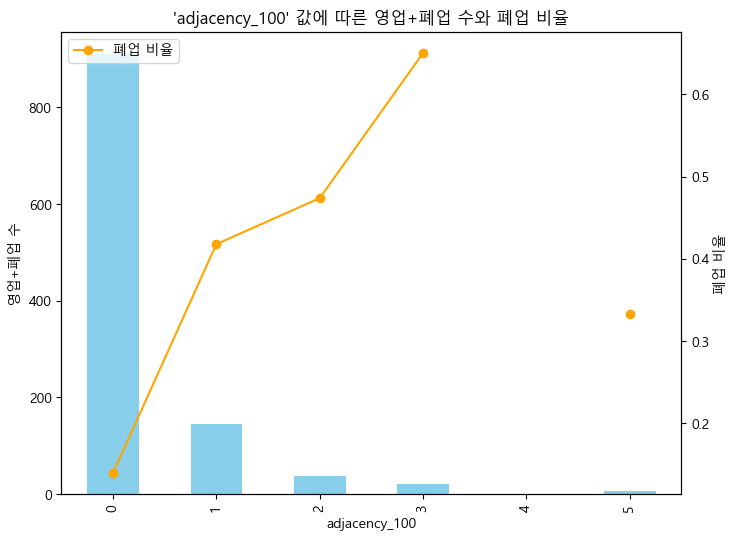

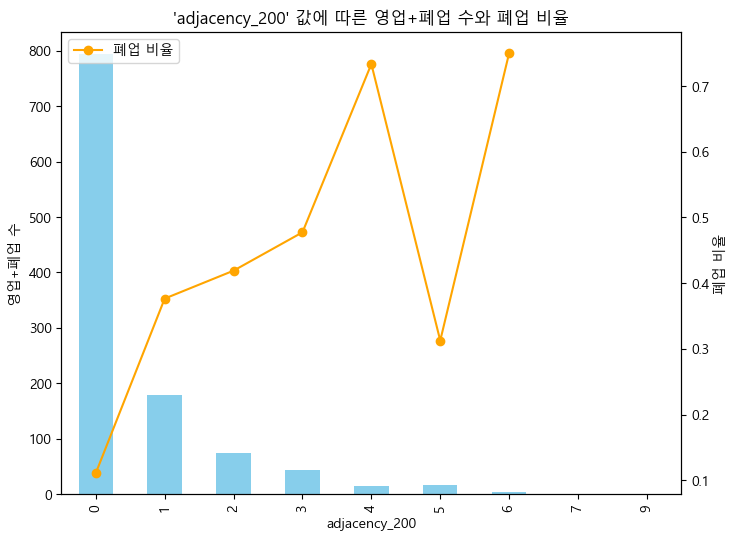

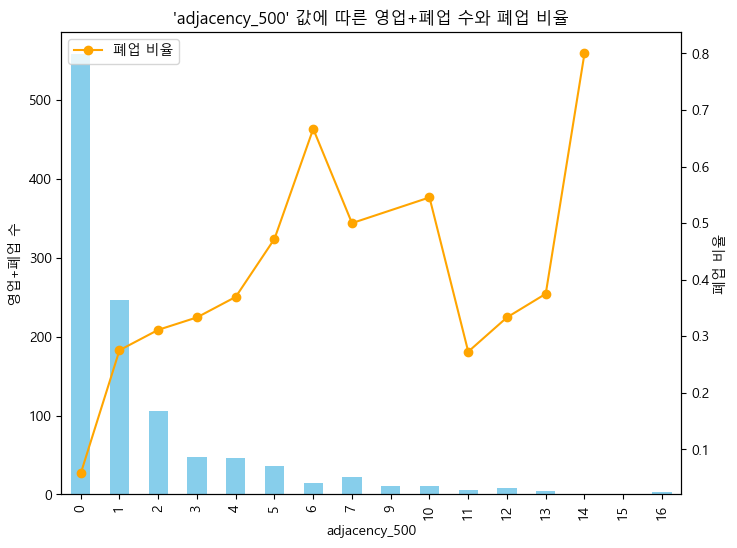

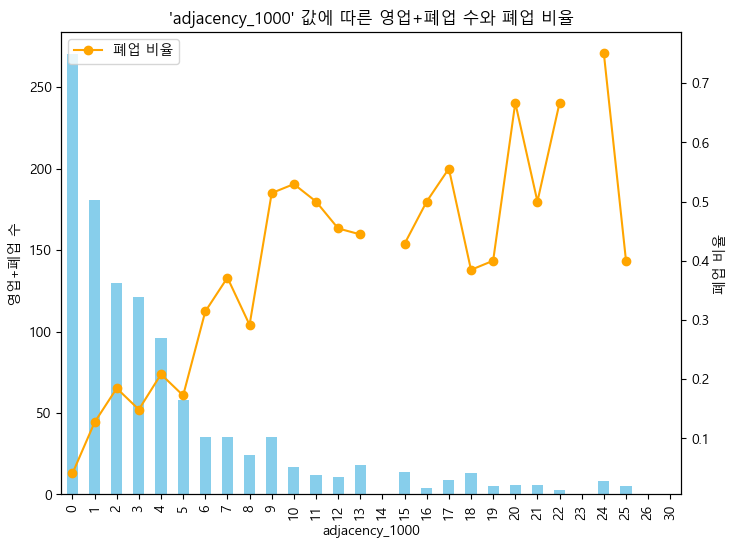

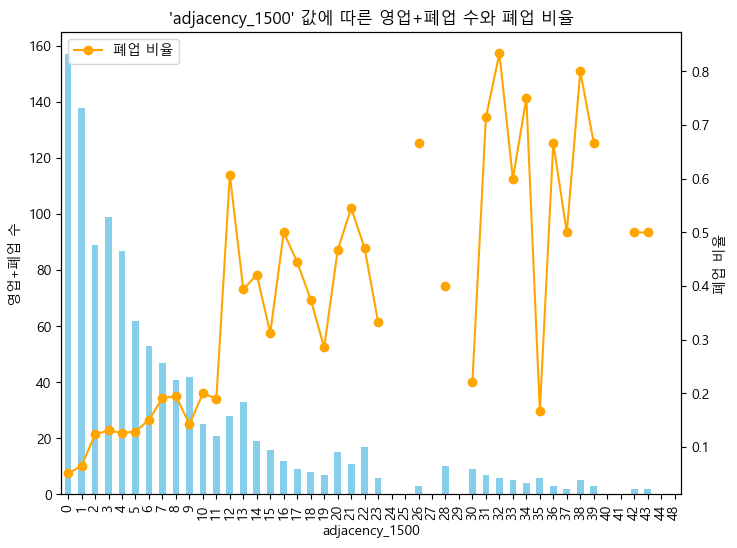

In [193]:
columns = ['adjacency_100', 'adjacency_200', 'adjacency_500', 'adjacency_1000', 'adjacency_1500']

for col in columns:
    result = bab_adj.groupby([col, 'status']).size().unstack()
    result['영업+폐업'] = result['폐업'] + result['영업/정상']
    result['폐업 비율'] = result['폐업'] / (result['폐업'] + result['영업/정상'])

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # 막대 그래프 (영업+폐업)
    result['영업+폐업'].plot(kind='bar', ax=ax1, color='skyblue', label='영업+폐업')
    ax1.set_xlabel(col)
    ax1.set_ylabel('영업+폐업 수')
    ax1.tick_params(axis='y')

    # 선 그래프 (폐업 비율)
    ax2 = ax1.twinx()
#     sns.regplot(data=result, x=result.index, y='폐업 비율', ax=ax2, scatter=False, line_kws={'color': 'red'})
    result['폐업 비율'].plot(kind='line', ax=ax2, color='orange', marker='o', label='폐업 비율')
    ax2.set_ylabel('폐업 비율')
    ax2.tick_params(axis='y')
    
    # 그래프 타이틀
    plt.title(f"'{col}' 값에 따른 영업+폐업 수와 폐업 비율")
    plt.legend(loc='upper left')
    plt.show()